# Models

Group project for the 2019 Data Science Workshop at the University of California, Berkeley.

The project is the Google Analytics Customer Revenue Prediction competition on Kaggle: https://www.kaggle.com/c/ga-customer-revenue-prediction

Group members:

* Andy Vargas (mentor)
* Yuem Park
* Marvin Pohl
* Michael Yeh

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

from sklearn.utils import resample
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

pd.options.display.max_columns = 999

Read in the data:

In [2]:
data_match = pd.read_csv('./data/train_df_match.csv', dtype={'fullVisitorId':'str'})
data_01 = pd.read_csv('./data/train_df_01.csv', dtype={'fullVisitorId':'str'})
data_02 = pd.read_csv('./data/train_df_02.csv', dtype={'fullVisitorId':'str'})
data_03 = pd.read_csv('./data/train_df_03.csv', dtype={'fullVisitorId':'str'})
data_04 = pd.read_csv('./data/train_df_04.csv', dtype={'fullVisitorId':'str'})
data_05 = pd.read_csv('./data/train_df_05.csv', dtype={'fullVisitorId':'str'})

Clean up some things:

In [3]:
# get rid of some features
training_cols = []
for col in data_match.columns:
    if ('trafficSource.medium.' not in col) and (col != 'totals.sessionQualityDim'):
        training_cols.append(col)

all_data = [data_match, data_01, data_02, data_03, data_04, data_05]

for i in range(len(all_data)):
    
    # add a column for DNR, RZR, RPR
    all_data[i].loc[all_data[i]['return_flag']==0,'stratify_flag']='DNR'
    all_data[i].loc[(all_data[i]['return_flag']==1)&(all_data[i]['total_predict_revenue']==0),'stratify_flag']='RZR'
    all_data[i].loc[(all_data[i]['return_flag']==1)&(all_data[i]['total_predict_revenue']!=0),'stratify_flag']='RPR'
    
# pull out only RPR data
data_match = data_match[data_match['stratify_flag']=='RPR'].copy()
data_01 = data_01[data_01['stratify_flag']=='RPR'].copy()
data_02 = data_02[data_02['stratify_flag']=='RPR'].copy()
data_03 = data_03[data_03['stratify_flag']=='RPR'].copy()
data_04 = data_04[data_04['stratify_flag']=='RPR'].copy()
data_05 = data_05[data_05['stratify_flag']=='RPR'].copy()

data_match.reset_index(drop=True, inplace=True)
data_01.reset_index(drop=True, inplace=True)
data_02.reset_index(drop=True, inplace=True)
data_03.reset_index(drop=True, inplace=True)
data_04.reset_index(drop=True, inplace=True)
data_05.reset_index(drop=True, inplace=True)

# get rid of some of the features
data_match = data_match[training_cols]
data_01 = data_01[training_cols]
data_02 = data_02[training_cols]
data_03 = data_03[training_cols]
data_04 = data_04[training_cols]
data_05 = data_05[training_cols]

# combine the XX dataframes
data_XX = pd.concat([data_01,data_02,data_03,data_04,data_05], ignore_index=True)

# get feature and target column names
X_cols = []
for col in data_match.columns:
    if (col!='total_predict_revenue') and (col!='return_flag') and (col!='stratify_flag') and (col!='fullVisitorId'):
        X_cols.append(col)
        
Y_cols = ['total_predict_revenue']

# split features and targets
X_match = data_match[X_cols]
Y_match = data_match[Y_cols]

X_XX = data_XX[X_cols]
Y_XX = data_XX[Y_cols]

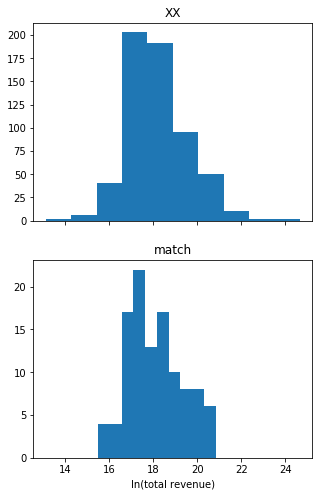

In [4]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(5,8), sharex=True)

ax[0].hist(np.log(Y_XX.values.ravel()))
ax[0].set_title('XX')

ax[1].hist(np.log(Y_match.values.ravel()))
ax[1].set_title('match')
ax[1].set_xlabel('ln(total revenue)')

plt.show(fig)

## Baseline

In [5]:
def get_RMSE(Y, Y_prediction):
    RMSE = np.sqrt(mean_squared_error(np.log(Y), np.log(Y_prediction)))
    return RMSE

Just predict the mean, and see what the RMSE is:

In [6]:
Y_match_baseline = np.ones(len(Y_match)) * np.mean(Y_match.values)
Y_XX_baseline = np.ones(len(Y_XX)) * np.mean(Y_XX.values)

RMSE_match_baseline = get_RMSE(Y_match, Y_match_baseline)
RMSE_XX_baseline = get_RMSE(Y_XX, Y_XX_baseline)

print('match baseline RMSE = {:.6f}'.format(RMSE_match_baseline))
print('XX    baseline RMSE = {:.6f}'.format(RMSE_XX_baseline))

match baseline RMSE = 1.528452
XX    baseline RMSE = 2.054155


## Random Forest Regressor - Match Data Only

Just look at the "match" training slice, which matches the dates exactly of the evaluation set, but one year previous.

Here, we perform `n_loops`, where on each loop we randomly sample `n_samples`. We train the Random Forest Regressor on this sample set (which we refer to as `train`), and evaluate its performance on the remaining samples (which we refer to as `test` here).

In [7]:
len(Y_match)

109

In [8]:
#####################################
# set the number of loops to run here, along with the number of samples to bootstrap each loop
n_loops = 50
n_samples = 75
#####################################

#####################################
# set the hyperparameter tuning space here
max_depth_HPT_1 = np.arange(2, 20, 2)
min_samples_leaf_HPT_1 = np.arange(1, 15, 1)
#####################################

index = np.arange(len(X_match))

# set up mean and std RMSE storage arrays
RMSE_mean_train_HPT_1 = np.zeros((len(max_depth_HPT_1), len(min_samples_leaf_HPT_1)))
RMSE_std_train_HPT_1 = np.zeros((len(max_depth_HPT_1), len(min_samples_leaf_HPT_1)))

RMSE_mean_test_HPT_1 = np.zeros((len(max_depth_HPT_1), len(min_samples_leaf_HPT_1)))
RMSE_std_test_HPT_1 = np.zeros((len(max_depth_HPT_1), len(min_samples_leaf_HPT_1)))

# seed the RNG
np.random.seed(2019)

# loop over the hyperparameter space
for i in tqdm_notebook(range(len(max_depth_HPT_1)), desc='max_depth'):
    for j in tqdm_notebook(range(len(min_samples_leaf_HPT_1)), desc='min_samples_leaf', leave=False):

        RMSEs_train = np.zeros(n_loops)
        RMSEs_test = np.zeros(n_loops)

        # loop over the bootstrapping
        for k in tqdm_notebook(range(n_loops), desc='bootstrap', leave=False):

            # take a sample
            index_slice = resample(index, replace=False, n_samples=n_samples)

            # extract X and Y
            X_train = X_match.loc[index_slice]
            Y_train = Y_match.loc[index_slice]
            
            X_test = X_match.loc[~X_match.index.isin(index_slice)]
            Y_test = Y_match.loc[~Y_match.index.isin(index_slice)]

            # set up the RFR
            RFR = RandomForestRegressor(max_depth=max_depth_HPT_1[i],
                                        min_samples_leaf=min_samples_leaf_HPT_1[j],
                                        n_estimators=50,bootstrap=True,criterion='mse')

            # fit
            RFR.fit(X_train, Y_train.values.ravel())

            # predict
            Y_train_prediction = RFR.predict(X_train)
            Y_test_prediction = RFR.predict(X_test)

            # calculate RMSE
            RMSE_train = get_RMSE(Y_train, Y_train_prediction)
            RMSE_test = get_RMSE(Y_test, Y_test_prediction)

            # store
            RMSEs_train[k] = RMSE_train
            RMSEs_test[k] = RMSE_test
            
        # store averages
        RMSE_mean_train_HPT_1[i,j] = np.mean(RMSEs_train)
        RMSE_std_train_HPT_1[i,j] = np.std(RMSEs_train)
        
        RMSE_mean_test_HPT_1[i,j] = np.mean(RMSEs_test)
        RMSE_std_test_HPT_1[i,j] = np.std(RMSEs_test)

In [9]:
print('best test RMSE = {:.6f}'.format(np.min(RMSE_mean_test_HPT_1)))

best test RMSE = 1.327054


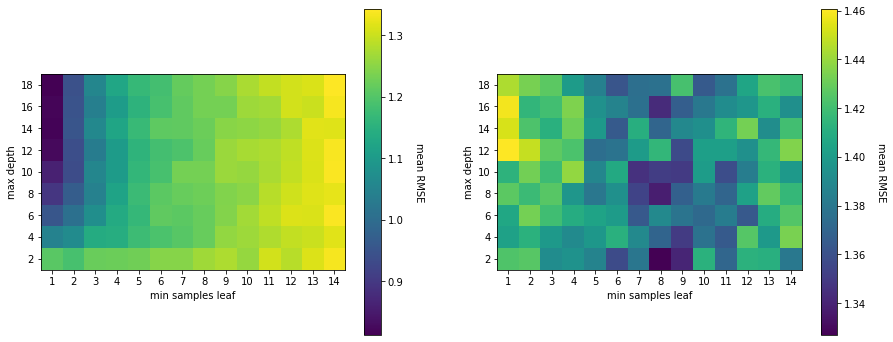

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

im0 = ax[0].imshow(RMSE_mean_train_HPT_1, origin='lower')
im1 = ax[1].imshow(RMSE_mean_test_HPT_1, origin='lower')

cbar0 = fig.colorbar(im0, ax=ax[0])
cbar0.ax.set_ylabel('mean RMSE', rotation=-90, labelpad=20)

cbar1 = fig.colorbar(im1, ax=ax[1])
cbar1.ax.set_ylabel('mean RMSE', rotation=-90, labelpad=20)

for i in range(2):
    ax[i].set_xticks(np.arange(len(min_samples_leaf_HPT_1)))
    ax[i].set_xticklabels(min_samples_leaf_HPT_1)
    ax[i].set_xlabel('min samples leaf')

    ax[i].set_yticks(np.arange(len(max_depth_HPT_1)))
    ax[i].set_yticklabels(max_depth_HPT_1)
    ax[i].set_ylabel('max depth')

plt.show(fig)

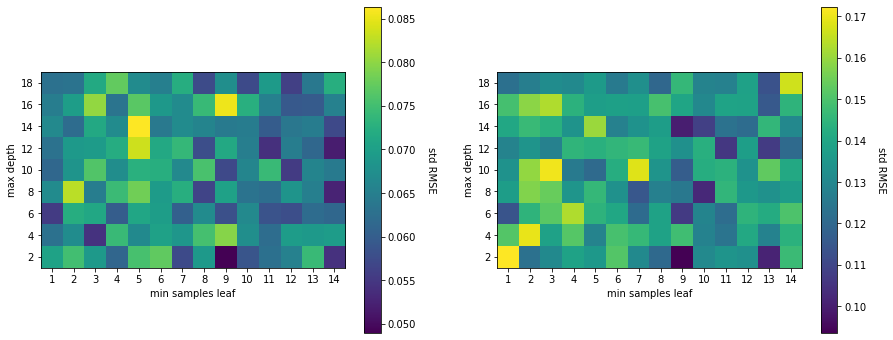

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

im0 = ax[0].imshow(RMSE_std_train_HPT_1, origin='lower')
im1 = ax[1].imshow(RMSE_std_test_HPT_1, origin='lower')

cbar0 = fig.colorbar(im0, ax=ax[0])
cbar0.ax.set_ylabel('std RMSE', rotation=-90, labelpad=20)

cbar1 = fig.colorbar(im1, ax=ax[1])
cbar1.ax.set_ylabel('std RMSE', rotation=-90, labelpad=20)

for i in range(2):
    ax[i].set_xticks(np.arange(len(min_samples_leaf_HPT_1)))
    ax[i].set_xticklabels(min_samples_leaf_HPT_1)
    ax[i].set_xlabel('min samples leaf')

    ax[i].set_yticks(np.arange(len(max_depth_HPT_1)))
    ax[i].set_yticklabels(max_depth_HPT_1)
    ax[i].set_ylabel('max depth')

plt.show(fig)

## Random Forest Regressor - XX Data

Train on the "XX" slices, which are just 5 even spaces time slices in the training.csv concatenated together. This approach ignores seasonality, but increases the number of data points that we use to train with.

Here, we perform `n_loops`, where on each loop we randomly sample `n_samples`. We train the Random Forest Regressor on this sample set (which we refer to as `train`), and evaluate its performance on the remaining samples (which we refer to as `test` here). We will also evaluate model performance on the "match" slice (which we refer to as `match_test` here).

In [12]:
len(Y_XX)

603

In [16]:
#####################################
# set the number of loops to run here, along with the number of samples to bootstrap each loop
n_loops = 25
n_samples = 500
#####################################

#####################################
# set the hyperparameter tuning space here
max_depth_HPT_2 = np.arange(5, 50, 5)
min_samples_leaf_HPT_2 = np.arange(1, 10, 1)
#####################################

index = np.arange(len(X_XX))

# set up mean and std RMSE storage arrays
RMSE_mean_train_HPT_2 = np.zeros((len(max_depth_HPT_2), len(min_samples_leaf_HPT_2)))
RMSE_std_train_HPT_2 = np.zeros((len(max_depth_HPT_2), len(min_samples_leaf_HPT_2)))

RMSE_mean_test_HPT_2 = np.zeros((len(max_depth_HPT_2), len(min_samples_leaf_HPT_2)))
RMSE_std_test_HPT_2 = np.zeros((len(max_depth_HPT_2), len(min_samples_leaf_HPT_2)))

RMSE_mean_match_test_HPT_2 = np.zeros((len(max_depth_HPT_2), len(min_samples_leaf_HPT_2)))
RMSE_std_match_test_HPT_2 = np.zeros((len(max_depth_HPT_2), len(min_samples_leaf_HPT_2)))

# seed the RNG
np.random.seed(2019)

# loop over the hyperparameter space
for i in tqdm_notebook(range(len(max_depth_HPT_2)), desc='max_depth'):
    for j in tqdm_notebook(range(len(min_samples_leaf_HPT_2)), desc='min_samples_leaf', leave=False):

        RMSEs_train = np.zeros(n_loops)
        RMSEs_test = np.zeros(n_loops)
        RMSEs_match_test = np.zeros(n_loops)

        # loop over the bootstrapping
        for k in tqdm_notebook(range(n_loops), desc='bootstrap', leave=False):

            # take a sample
            index_slice = resample(index, replace=False, n_samples=n_samples)

            # extract X and Y
            X_train = X_XX.loc[index_slice]
            Y_train = Y_XX.loc[index_slice]
            
            X_test = X_XX.loc[~X_XX.index.isin(index_slice)]
            Y_test = Y_XX.loc[~Y_XX.index.isin(index_slice)]

            # set up the RFR
            RFR = RandomForestRegressor(max_depth=max_depth_HPT_2[i],
                                        min_samples_leaf=min_samples_leaf_HPT_2[j],
                                        n_estimators=50,bootstrap=True,criterion='mse')

            # fit
            RFR.fit(X_train, Y_train.values.ravel())

            # predict
            Y_train_prediction = RFR.predict(X_train)
            Y_test_prediction = RFR.predict(X_test)
            Y_match_test_prediction = RFR.predict(X_match)

            # calculate RMSE
            RMSE_train = get_RMSE(Y_train, Y_train_prediction)
            RMSE_test = get_RMSE(Y_test, Y_test_prediction)
            RMSE_match_test = get_RMSE(Y_match, Y_match_test_prediction)

            # store
            RMSEs_train[k] = RMSE_train
            RMSEs_test[k] = RMSE_test
            RMSEs_match_test[k] = RMSE_match_test
            
        # store averages
        RMSE_mean_train_HPT_2[i,j] = np.mean(RMSEs_train)
        RMSE_std_train_HPT_2[i,j] = np.std(RMSEs_train)
        
        RMSE_mean_test_HPT_2[i,j] = np.mean(RMSEs_test)
        RMSE_std_test_HPT_2[i,j] = np.std(RMSEs_test)
        
        RMSE_mean_match_test_HPT_2[i,j] = np.mean(RMSEs_match_test)
        RMSE_std_match_test_HPT_2[i,j] = np.std(RMSEs_match_test)

In [17]:
print('best test RMSE       = {:.6f}'.format(np.min(RMSE_mean_test_HPT_2)))
print('best match test RMSE = {:.6f}'.format(np.min(RMSE_mean_match_test_HPT_2)))

best test RMSE       = 1.414864
best match test RMSE = 1.225718


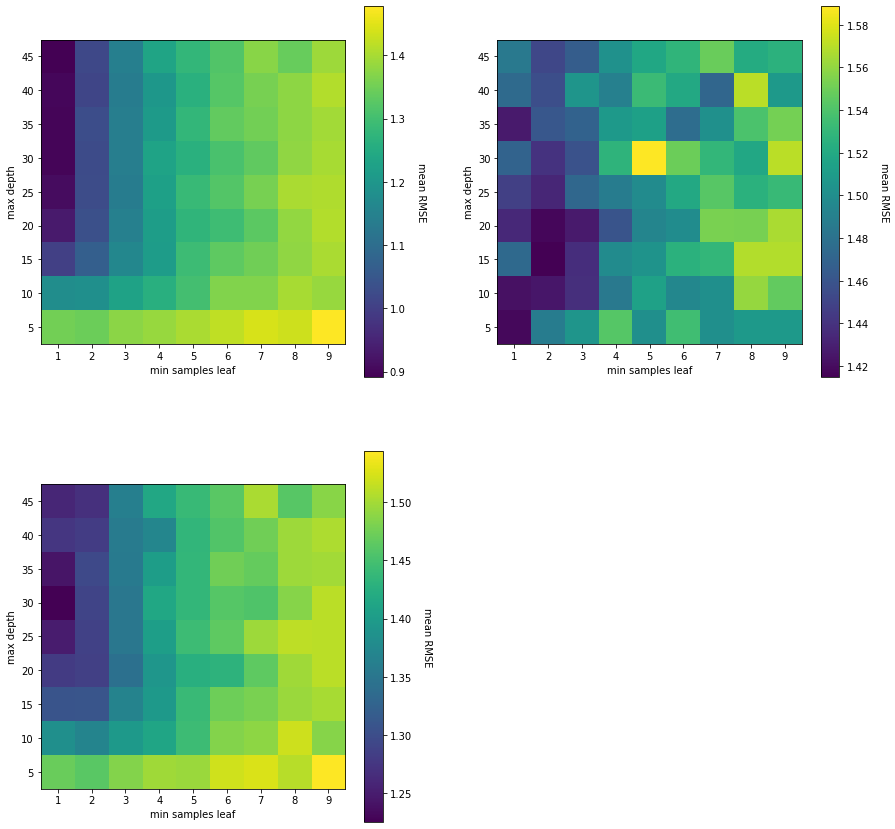

In [19]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,15))

ax = ax.flatten()

im0 = ax[0].imshow(RMSE_mean_train_HPT_2, origin='lower')
im1 = ax[1].imshow(RMSE_mean_test_HPT_2, origin='lower')
im2 = ax[2].imshow(RMSE_mean_match_test_HPT_2, origin='lower')

ax[3].axis('off')

cbar0 = fig.colorbar(im0, ax=ax[0])
cbar0.ax.set_ylabel('mean RMSE', rotation=-90, labelpad=20)

cbar1 = fig.colorbar(im1, ax=ax[1])
cbar1.ax.set_ylabel('mean RMSE', rotation=-90, labelpad=20)

cbar2 = fig.colorbar(im2, ax=ax[2])
cbar2.ax.set_ylabel('mean RMSE', rotation=-90, labelpad=20)

for i in range(3):
    ax[i].set_xticks(np.arange(len(min_samples_leaf_HPT_2)))
    ax[i].set_xticklabels(min_samples_leaf_HPT_2)
    ax[i].set_xlabel('min samples leaf')

    ax[i].set_yticks(np.arange(len(max_depth_HPT_2)))
    ax[i].set_yticklabels(max_depth_HPT_2)
    ax[i].set_ylabel('max depth')

plt.show(fig)

## Notes

| model | RMSE |
|-------|------|
| match baseline | 1.528452 |
| XX baseline | 2.054155 |
| match RFR | 1.327054 |